# Introduction
This notebook contains a working example of the Similarity Based Saliency Maps (SBSM) API for choosing to use 
an occlusion-based saliency map algorithm.

This example will follow an application-like use case where we define a functionally rigid process that transforms input images into saliency heatmaps based on their similarity with a probe image in embedding space.

We will show that it is easy to change which of our API implementations are used in the application without impacting the application's successful execution, using a sliding-window perturbation algorithm.

This will necessarily include the use of a deep model for feature vector generation that we will be determining the saliency for.
We will fill this role here with a PyTorch Imagenet-pretrained ResNet18 network truncated after the last global average pooling layer.

### Table of Contents
* [Set Up Environment](#Set-Up-Environment-similarity)
* [The Test Images](#The-test-images-similarity)
* [The "Application"](#The-application-similarity)
* [Feature Extraction Model](#Feature-Extraction-Model-similarity)
* [XAI Components](#XAI-Components-similarity)
* [Calling the Application](#Calling-the-Application-similarity)

### Miscellaneous
License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Dong, Bo, Roddy Collins, and Anthony Hoogs. "Explainability for Content-Based Image Retrieval." CVPR Workshops. 2019.

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/SimilarityScoring.ipynb)

# Set Up Environment <a name="Set-Up-Environment-similarity"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q "torch==1.9.0"
!{sys.executable} -m pip install -q "torchvision==0.10.0"

# The Test Images <a name="The-test-images-similarity"></a>
We will test this application on the following images.
We know that these images contains the Imagenet class of "boxer" and the superclass "dog".

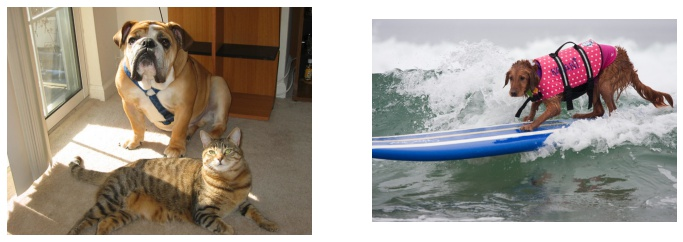

In [2]:
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Test images to be explained
test_image1_path = 'data/catdog.jpg'
urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', test_image1_path)

test_image2_path = 'data/dog.jpg'
urllib.request.urlretrieve('https://farm5.staticflickr.com/4089/4990202073_725f035a15_z.jpg', test_image2_path)

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(PIL.Image.open(test_image1_path))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(PIL.Image.open(test_image2_path))

# The "Application" <a name="The-application-similarity"></a>
First, we will set up our application as a function with defined inputs for the following:
  * the query and reference images
  * feature extraction model
  * image perturbation API implementation
  * saliency map generation API implementation

For the purposes of this tool, let's say that the input feature extractor must take in one image and output a 1D feature vector (`Callable[[PIL.Image.Image], np.ndarray]`) for simplicity.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Callable, Optional, Sequence, Union
from xaitk_saliency import PerturbImage, GenerateDescriptorSimilaritySaliency
from xaitk_saliency.utils.masking import occlude_image_batch


def app(
    image_filepath_1: str,
    image_filepath_2: str,
    BlackboxModel: Callable[[np.ndarray], np.ndarray],
    perturber: PerturbImage,
    similarity_alg: GenerateDescriptorSimilaritySaliency,
    fill: Optional[Union[int, Sequence[int]]] = None,
    vis_mask_examples: bool = False,
):
    # Load the image
    query_image = np.array(PIL.Image.open(image_filepath_1))
    ref_image = np.array(PIL.Image.open(image_filepath_2))
    
    # Compute original feature vector on test images
    query_feat = BlackboxModel(query_image)
    ref_feat = BlackboxModel(ref_image)
    # Use the perturbation API implementation input to generate a bunch of images.
    # We will use the outputs here multiple times later so we will just aggregate
    # the output here.
    pert_masks = perturber(ref_image)
    print(f"perturbation masks: {pert_masks.shape}")
    
    # For the saliency heatmap generation API we need reference image feature vector as well as
    # the feature vectors for each of the perturbed reference images.
    pertbd_ref_imgs = occlude_image_batch(ref_image, pert_masks, fill)
    print(f"perturbed Reference images: {len(pertbd_ref_imgs)}")
    pert_feat_ref = np.asarray([
        BlackboxModel(pi)
        for pi in pertbd_ref_imgs
    ])
    # Visualize some example perturbed images before heading into similarity based saliency algorithm
    if vis_mask_examples:
        n = 4
        print(f"Visualizing {n} random perturbed reference images...")
        rng = np.random.default_rng(seed=0)
        rng_idx_lst = sorted(rng.integers(0, len(pert_masks)-1, n))
        plt.figure(figsize=(n*4, 3))
        for i, rnd_i in enumerate(rng_idx_lst):
            plt.subplot(1, n, i+1)
            plt.title(f"pert_imgs[{rnd_i}]")
            plt.axis('off')
            plt.imshow(pertbd_ref_imgs[rnd_i])

    print(f"Pert features: {pert_feat_ref.shape}")

    # Generating final similarity based saliency map
    sal_maps = similarity_alg(query_feat,
                               ref_feat,
                               pert_feat_ref,
                               pert_masks)

    sub_plot_ind = len(sal_maps) + 2
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(query_image)
    plt.axis('off')
    plt.title('Query Image')

    plt.subplot(2, sub_plot_ind, 2)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Reference Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[1]/ref_image.shape[0]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Reference saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 3+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Reference Image #{i+1} Pos Saliency")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+3+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Reference Image #{i+1} Neg Saliency")
        plt.axis('off')
    plt.show()
    plt.close()

# Feature-Extraction Model <a name="Feature-Extraction-Model-similarity"></a>
In this example, we will use a basic PyTorch-based, pretrained ResNet18 model truncated after the global average pooling (GAP) layer and use GAP's output as the feature vector representing content of the input image.
The ResNet18 model results in a 512 dimension feature vector after the GAP layer in a ResNet18.

In [4]:
import torchvision.models as models
import torch
from torch import nn

CUDA_AVAILABLE = torch.cuda.is_available()

# Creating an example deep feature extractor to describe images
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])
model = model.eval()

if CUDA_AVAILABLE:
    model = model.cuda()

# XAI Components <a name="XAI-Components-similarity"></a>
Here we will set up XAI components that comprise image perturbation and similarity-based saliency map generation.

We will start with the sliding-window perturbation method and the similarity-based saliency map generation method.

In [5]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindow
from xaitk_saliency.impls.gen_descriptor_sim_sal.similarity_scoring import SimilarityScoring

# Constructing xaitk implementations for SimilarityBased Saliency generation with
# sliding windows based perturbers.
slid_algo = SlidingWindow(window_size=(40, 40), stride=(15, 15))

similarity_alg = SimilarityScoring()

In [6]:
from torch.autograd import Variable
from torchvision import transforms


class SimilarityBlackbox():
    
    def __init__(self,
                model):
        self.model = model
        self.model_input_size = (224, 224)
        self.model_mean = [0.485, 0.456, 0.406]
        self.blackbox_fill = np.uint8(np.asarray(self.model_mean) * 255)    
        self.model_loader = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.model_input_size), 
            transforms.ToTensor(),
            transforms.Normalize(
                mean=self.model_mean,
                std=[0.229, 0.224, 0.225]
            ),
            ])

    def image_loader(self, image):
        image = self.model_loader(image).float()
        image = Variable(image, requires_grad=False)
        if CUDA_AVAILABLE:
            image = image.cuda()
        return image.unsqueeze(0)

    @torch.no_grad()
    def __call__(self, image):
        featureVec = self.model(self.image_loader(image))
        return featureVec.cpu().detach().numpy().squeeze()

simbbox = SimilarityBlackbox(model)

# Calling the Application <a name="Calling-the-Application-similarity"></a>
Here we will show that we can invoke the same "application" (function) with different `xaitk-saliency` API interface implementations while still successfully executing and visualizing the different results that are generated.

### Salient regions in images 'a' and 'b'. 
In the below example, we demonstrate the ability to compute salient regions both between two images and the same image. Regions within computed self-similarity generally track the regions encoded by the feature vector.
* a -> b
* b -> a
* a -> a
* b -> b

Note that the original implementation of SBSM intentionally constrains its saliency values to the [0,1] range due to only trying to explain regions of positive influence. Therefore the negative saliency maps appear to be empty.

perturbation masks: (1247, 427, 640)
perturbed Reference images: 1247
Visualizing 4 random perturbed reference images...
Pert features: (1247, 512)
Reference saliency map range: [0.0, 1.0]


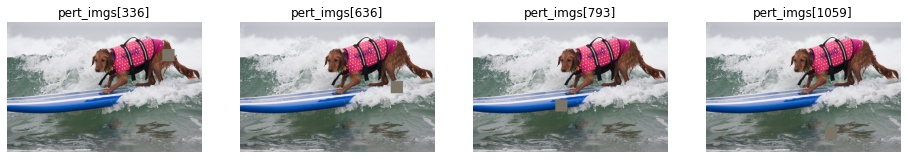

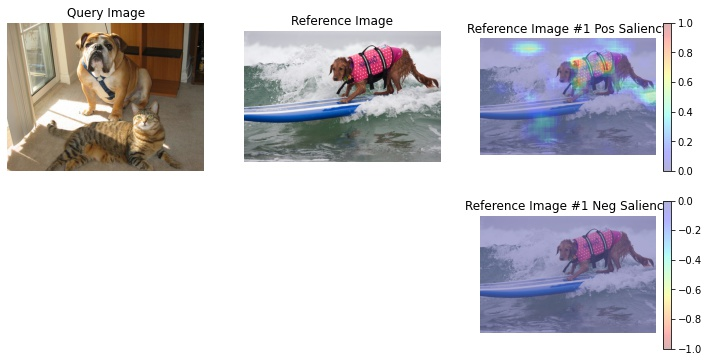

perturbation masks: (1376, 480, 640)
perturbed Reference images: 1376
Pert features: (1376, 512)
Reference saliency map range: [0.0, 1.0]


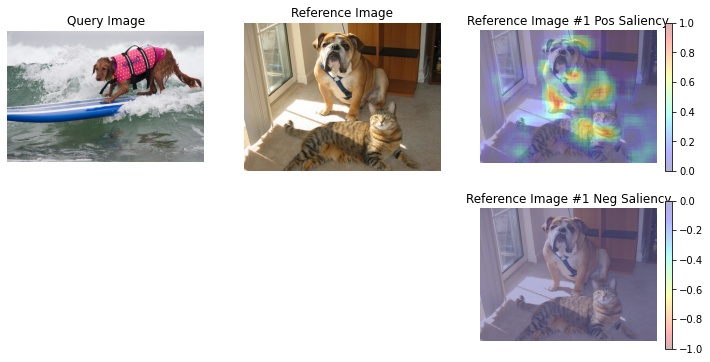

perturbation masks: (1376, 480, 640)
perturbed Reference images: 1376
Pert features: (1376, 512)
Reference saliency map range: [0.06067274433212215, 1.0]


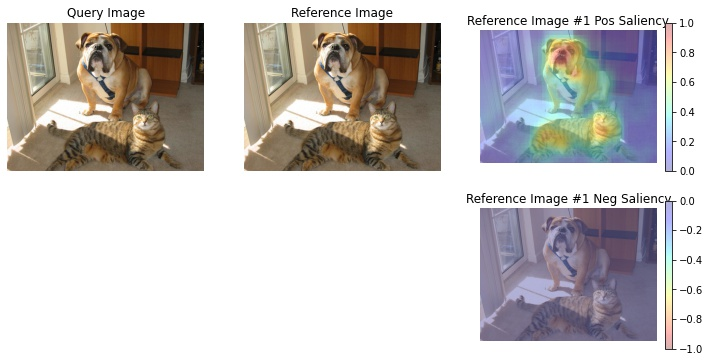

perturbation masks: (1247, 427, 640)
perturbed Reference images: 1247
Pert features: (1247, 512)
Reference saliency map range: [0.07900027549856886, 1.0]


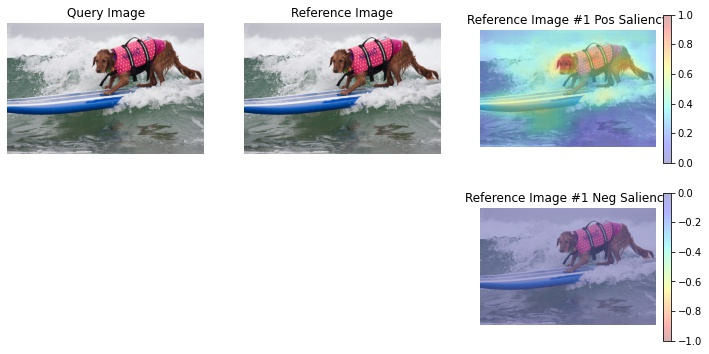

In [7]:
# Computing saliency across all combinations of the two test images as query 
# and reference images for Sliding Window-based perturbation
sal_maps = app(
    test_image1_path,
    test_image2_path,
    simbbox,
    slid_algo,
    similarity_alg,
    fill=simbbox.blackbox_fill,
    vis_mask_examples=True,
)
sal_maps = app(
    test_image2_path, # The change
    test_image1_path, # The change
    simbbox,
    slid_algo,
    similarity_alg,
    fill=simbbox.blackbox_fill,
)
sal_maps = app(
    test_image1_path,
    test_image1_path, # The change
    simbbox,
    slid_algo,
    similarity_alg,
    fill=simbbox.blackbox_fill,
)
sal_maps = app(
    test_image2_path, # The change
    test_image2_path, # The change
    simbbox,
    slid_algo,
    similarity_alg,
    fill=simbbox.blackbox_fill,
)